In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
#   try:
#     tf.config.set_logical_device_configuration(
#         gpus[0],
#         [tf.config.LogicalDeviceConfiguration(memory_limit=6024)])
#     logical_gpus = tf.config.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Virtual devices must be set before GPUs have been initialized
#     print(e)

In [3]:
Image_Size = 256
Batch_Size = 64
Channels = 3
N_classes = 4

In [4]:
Dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'Apple Leaves/',
    shuffle = True,
    image_size = (Image_Size , Image_Size),
    batch_size = Batch_Size
)

Found 3642 files belonging to 4 classes.


In [5]:
# Test_Data = tf.keras.preprocessing.image_dataset_from_directory(
#     'Test Data/',
#     shuffle = True,
#     image_size = (Image_Size , Image_Size),
#     batch_size = Batch_Size
# )

In [6]:
class_names = Dataset.class_names
class_names

['Healthy', 'Multiple', 'Rust', 'Scab']

In [7]:
print("Train : " , len(Dataset))
# print("Test : " , len(Test_Data))

Train :  57


In [8]:
for image_batch , label_batch in Dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    print(image_batch[0])

(64, 256, 256, 3)
[2 2 0 1 3 3 3 2 2 0 2 0 2 2 2 0 3 2 3 0 3 3 2 0 0 1 3 0 3 2 3 3 2 1 0 0 2
 3 2 0 0 0 2 3 0 3 2 2 0 3 2 2 2 0 2 3 2 3 2 3 0 3 2 3]
tf.Tensor(
[[[137.91699  163.91699   74.58496 ]
  [130.25098  164.75098   59.66797 ]
  [125.50195  162.91895   45.833984]
  ...
  [199.33203  200.83203   50.33203 ]
  [227.16602  220.66602   76.166016]
  [230.58301  225.58301   69.91504 ]]

 [[136.24902  163.24902   70.24902 ]
  [124.00391  158.5039    50.003906]
  [110.76074  146.76074   39.756836]
  ...
  [211.74316  209.99805   60.99414 ]
  [230.5      224.        79.5     ]
  [233.75098  227.75098   78.74707 ]]

 [[144.99023  170.16016   85.65039 ]
  [131.49023  164.99023   65.15039 ]
  [116.32031  150.90527   52.15039 ]
  ...
  [224.16016  218.74512   72.490234]
  [233.83008  226.83008   83.83008 ]
  [236.83008  229.83008   86.83008 ]]

 ...

 [[111.83984  130.58496   64.66992 ]
  [131.25488  145.91504   77.66016 ]
  [123.36914  133.0293    67.274414]
  ...
  [100.424805 122.009766  4

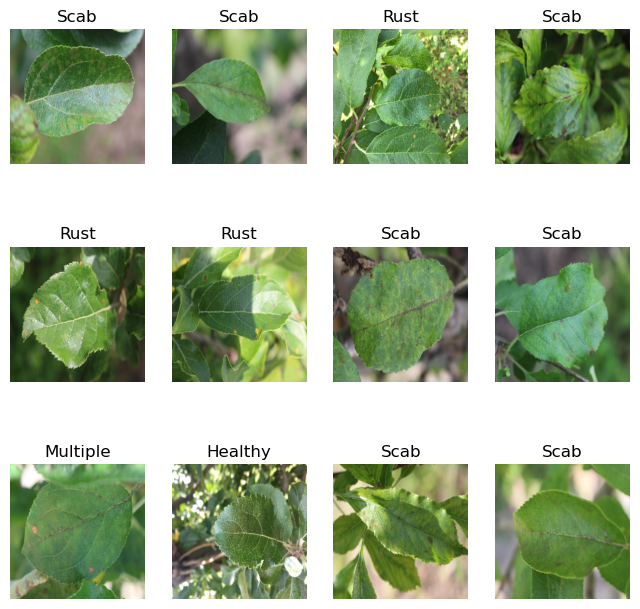

In [9]:
plt.figure(figsize=(8,8))

for image_batch , label_batch in Dataset.take(1):
    for i in range(12):
        plt.subplot(3 , 4 , i + 1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis('off')
        plt.title(class_names[label_batch[i]])

In [10]:
# Test_data1 = Test_Data.take(20)
# Validation = Test_Data.skip(20)
# Validation = Test_Data.take(20)

In [11]:
# print(len(Test_data1))
# print(len(Validation))

In [12]:
# plt.figure(figsize=(10,10))

# for image_batch , label_batch in Test_data1.take(1):
#     for i in range(12):
#         plt.subplot(3 , 4 , i + 1)
#         plt.imshow(image_batch[i].numpy().astype('uint8'))
#         plt.axis('off')
#         plt.title(class_names[label_batch[i]])

#### Train Test Split

In [13]:
# Train_data = Dataset.take(90)
# Test_data = Dataset.skip(90)
# Val_data = Test_data.skip(12)
# Test_data = Test_data.take(12)

In [14]:
def get_dataset_partition(DS , train_split=0.8 , val_split=0.1 , test_split=0.1 , shuffle=True , shuffle_size=1000):
    
    ds_size = len(DS)
    
    if shuffle:
        ds = DS.shuffle(shuffle_size , seed=12)
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_ds = DS.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return  train_ds , val_ds , test_ds

In [15]:
Train_data , Val_data , Test_data = get_dataset_partition(Dataset)

In [16]:
print(len(Train_data))
print(len(Test_data))
print(len(Val_data))

45
7
5


In [17]:
Train_data = Train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
Val_data = Val_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
Test_data = Test_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
Resize_and_Rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_Size,Image_Size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [19]:
Data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.4)
])

In [20]:
Input_shape = (Batch_Size,Image_Size,Image_Size,Channels)

Model = models.Sequential([
    Resize_and_Rescale,
    Data_augmentation,
    
    layers.Conv2D(32 , (3,3) , activation='relu' , input_shape = Input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64 , (3,3) , activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64 , (3,3) , activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64 , (3,3) , activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64 , (3,3) , activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128 , (3,3) , activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(128 , activation='relu'),
    layers.Dense(N_classes , activation='softmax')

])

Model.build(input_shape= Input_shape)

In [21]:
Model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (64, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (64, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (64, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (64, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (64, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (64, 62, 62, 64)         0         
 2D)                                                  

In [22]:
Model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [23]:
# gpu_opts = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.5)
# sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_opts))

In [ ]:
# with tf.device('gpu:1'):
History = Model.fit(
    Train_data,
    epochs=10,
    batch_size= 128,
    verbose=1,
    validation_data=Val_data
)

Epoch 1/10
45/45 [==============================] - 6s 119ms/step - loss: 0.7162 - accuracy: 0.6785 - val_loss: 0.7557 - val_accuracy: 0.6531
Epoch 2/10
45/45 [==============================] - 5s 117ms/step - loss: 0.6347 - accuracy: 0.6944 - val_loss: 0.6421 - val_accuracy: 0.7281
Epoch 3/10
45/45 [==============================] - 8s 188ms/step - loss: 0.5539 - accuracy: 0.7868 - val_loss: 0.5916 - val_accuracy: 0.7875
Epoch 4/10
29/45 [==================>...........] - ETA: 3s - loss: 0.5132 - accuracy: 0.8001

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

In [ ]:
Scores = Model.evaluate(Test_data)

In [ ]:
History.params

In [ ]:
History.history.keys()

In [ ]:
Acc = History.history['accuracy']
Val_acc = History.history['val_accuracy']

Loss = History.history['loss']
Val_loss = History.history['val_loss']

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.plot(range(50) , Acc , label='Training Accuracy')
plt.plot(range(50) , Val_acc , label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(50) , Loss , label='Training Loss')
plt.plot(range(50) , Val_loss , label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

In [ ]:
def predict(model , img):
#     img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img , 0)
    
    predictions = model.predict(img_array)
#     print(predictions)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])) , 2)
    return predicted_class , confidence

In [ ]:
plt.figure(figsize=(15,15))

for images , labels in Test_data.take(2):
    for i in range(9):
        ax = plt.subplot(3 ,3 , i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class , confidence = predict(Model , images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f'Actual : {actual_class} \n Predicted : {predicted_class}  \n Confidence : {confidence}')
        plt.axis('off')

In [ ]:
model_version = 'Model_1'
Model.save(f'Models/{model_version}')

In [ ]:
pwd